## Data manipulation

In [64]:
import pandas as pd

In [65]:
import matplotlib.pyplot as plt
import numpy
import ipywidgets as widgets
from IPython.display import display

In [66]:
geo_df = pd.read_csv(r'data\geo.csv')
iccs_df = pd.read_csv(r'data\iccs.csv')

In [ ]:
from dataclasses import dataclass

@dataclass
class Statistics:
    count_years: int = pd.NA
    count_fill_values: int = pd.NA
    first_fill_year: int = pd.NA
    last_fill_year: int = pd.NA
    mean_value: float = numpy.nan
    median_value: float = numpy.nan
    max_value: float = numpy.nan
    max_value_year: int = pd.NA
    min_value: float = numpy.nan
    min_value_year: int = pd.NA
    standard_deviation: float = numpy.nan
    quality_range_fill_data: int = pd.NA
    quality_range_unfill_data: int = pd.NA
    quality_data_info: str = pd.NA
    trend: str = pd.NA
    min_range_year: int = pd.NA
    max_range_year: int = pd.NA # otázka zda používat, je to informace pro range widget
    statistics_dictionary: dict = None
    
    def get_statistics_dict_info(self):
        self.statistics_dictionary = {
            'count_years': self.count_years,
            'count_fill_values': self.count_fill_values,            
            'first_fill_year': self.first_fill_year,
            'last_fill_year': self.last_fill_year,
            'mean_value': self.mean_value,
            'median_value': self.median_value,
            'max_value': self.max_value,
            'max_value_year': self.max_value_year,
            'min_value': self.min_value,
            'min_value_year': self.min_value_year,
            'standard_deviation': self.standard_deviation,
            'quality_range_fill_data': self.quality_range_fill_data,
            'quality_range_unfill_data': self.quality_range_unfill_data,
            'quality_data_info': self.quality_data_info,
            'trend': self.trend, 
            'min_range_year': self.min_range_year,
            'max_range_year': self.max_range_year
        }

    def check_trend(self, data):
        if self.quality_range_unfill_data != 0:
            self.trend = 'to missing value(s)'
        else:
            diffs = numpy.diff(data)
            sum_positive_number = numpy.sum(diffs > 0)
            sum_negative_number = numpy.sum(diffs < 0)
            # Pokud jsou rozdíly převážně kladné
            if sum_positive_number > sum_negative_number:
                self.trend = 'increasing'
            # Pokud jsou rozdíly převážně záporné
            elif sum_negative_number > sum_positive_number:
                self.trend = 'decreasing'
            else:
                self.trend = 'no clear trend'
        #TODO: možno upravit fci tak, aby u ojediněle chybějících hodnot doplnila pomocí lineární interpolace hodnoty.


    def get_quality_data(self, data = None, idx_first_fill_year = None, idx_last_fill_year = None):
        if self.count_fill_values == 0:
            self.quality_data_info = f'No record for crime.'

        elif self.count_fill_values == 1:
            self.quality_data_info = f'Only 1 record for crime.'
           
        else:
            count_fill_values_range = data[idx_first_fill_year:(idx_last_fill_year + 1)]['value'].count()
            count_fill_year_range = data[idx_first_fill_year:(idx_last_fill_year + 1)]['year'].count()
            self.quality_range_fill_data = count_fill_year_range
            self.quality_range_unfill_data = count_fill_year_range - count_fill_values_range

            if count_fill_values_range == count_fill_year_range:
                self.quality_data_info = 'The time series has no missing values within the data disclosure period.'
            else:
                number = count_fill_year_range - count_fill_values_range
                self.quality_data_info = f'The time series has {number} missing value(s) within the data disclosure period.'
            self.check_trend(data['value'])

            

    def calculate_from_data(self, data, code):
        if code != '1-1': # prozatimni ponechani, aby si clovek mohl filtroval tabulku, jak potrebuje
            self.quality_data_info = f'No statistics for this filtered data.'

        else:
            value_column = data['value']
            year_column = data['year']

            self.count_years = year_column.count()
            self.count_fill_values = value_column.count()

             # TODO: nutno pořešit v rámci změny filtrování, např. pokud budu mít všechny země, tento údaj úplně nědává smysl, 
            self.min_range_year = year_column.min() 
            self.max_range_year = year_column.max()

            if value_column.count() > 1:
                idx_first_fill_year = value_column.first_valid_index()
                self.first_fill_year = year_column[idx_first_fill_year]

                idx_last_fill_year = value_column.last_valid_index()
                self.last_fill_year = year_column[idx_last_fill_year]
               
                self.mean_value = round(value_column.mean(), 2)
                self.median_value = value_column.median()

                max_value_row = data.loc[data['value'].idxmax()]
                min_value_row = data.loc[data['value'].idxmin()]

                self.max_value, self.max_value_year = max_value_row[['value', 'year']]
                self.min_value, self.min_value_year = min_value_row[['value', 'year']]

                # použita populační směrodatná odchylka, ddof=1 ->nastavení na výběrovou směrodatnou odchylku
                self.standard_deviation = round(numpy.std(value_column), 2)
                
                self.get_quality_data(data, idx_first_fill_year, idx_last_fill_year)
                self.get_statistics_dict_info()

            elif value_column.count() == 1:
                idx_first_fill_year = value_column.first_valid_index()
                self.min_value = data.loc[idx_first_fill_year, 'value']
                self.min_value_year = data.loc[idx_first_fill_year, 'year']
                self.get_quality_data(data)
                self.get_statistics_dict_info()
                
            else:
                self.get_quality_data(data)
                self.get_statistics_dict_info()


@dataclass
class EurostatCrimeTable:
    data: pd.DataFrame = None
    country_list_sorted: list = None
    crime_list_sorted: list = None
    country: str = None 
    crime: str = None
    filtered_data: pd.DataFrame = None
    filtered_code: None = None
    statistics: Statistics = None
    statistics_info: str = None

    
    def _get_sorted_list(self, unpivot_data):
        country_list_sorted = sorted(unpivot_data['country_name'].unique())
        country_list_sorted.insert(0, 'all')
        self.country_list_sorted = country_list_sorted

        crime_list_sorted = sorted(unpivot_data['crime_info'].unique())
        crime_list_sorted.insert(0, 'all')
        self.crime_list_sorted = crime_list_sorted
        
        #TODO filtrace crime dle toho, jestli ma dana zeme u crime alespon 1 vyplnenou hodnotu


    def load_data(self, path=f'data/estat_crim_off_cat.tsv'):
        data = pd.read_csv(path, sep='\t')
        
        data = data.rename({data.columns[0]: data.columns[0].replace(r"\TIME_PERIOD", "")}, axis="columns")
        split_name_columns = (data.columns[0]).split(',')
        count_split_columns = len(split_name_columns)
        data[split_name_columns] = data[data.columns[0]].str.split(',', expand=True)
        data = data.drop(data.columns[0], axis="columns") #odstraneni jiz rozdeleneho sloupce

        data = data.merge(geo_df, how='left', on='geo')
        data = data.merge(iccs_df, how='left', on='iccs')
        data = data.drop(columns=['geo', 'iccs'])

        # presun rozdelenych a naparovaných udaju  na zacatek df
        reorg_columns = data.columns.tolist()
        final_reorg_columns = reorg_columns[-count_split_columns:] + reorg_columns[:-count_split_columns]
        data = data[final_reorg_columns]
        
        no_anual = data[data['freq'] != 'A'].index # podminka, ze se nejedna o rocni data
        data = data.drop(index=no_anual)

        no_p_hthab = data[data['unit'] != 'P_HTHAB'].index # podminka, ze se nejedna o udaj na 100tis obyvatel
        data = data.drop(index=no_p_hthab)

        years_list = data.columns[count_split_columns:]
        info_list = data.columns[:count_split_columns]

        unpivot_data = pd.melt(data, id_vars=info_list, value_vars=years_list, var_name='year', value_name='value')
        unpivot_data['year'] = unpivot_data['year'].astype('int')
        unpivot_data['value'] = unpivot_data['value'].replace([': ', '0 ', '0.00 ', 0], numpy.nan).astype('float')
        
        self._get_sorted_list(unpivot_data)
        self.data = unpivot_data
        
    def get_statistics(self):
        # _calculate_statistics
        data = self.filtered_data
        code = self.filtered_code

        stat = Statistics()
        stat.calculate_from_data(data, code)
        # TODO zaktivnit calc_func
        # self.calc_func(data, code)
        self.statistics = stat

        if pd.notna(stat.last_fill_year) and pd.notna(stat.max_range_year): #overeni vyplnebych hodnot - existence range     
            if stat.last_fill_year != stat.max_range_year:
                info = f'Data disclosure by the country began in {stat.first_fill_year} and ended in {stat.last_fill_year}.'
            elif stat.last_fill_year == stat.max_range_year:
                info = f'Data disclosure by the country began in {stat.first_fill_year} and continues until {stat.max_range_year}.'
        else:
            info = 'Data disclosure information is incomplete or missing.'
       
        
        if stat.count_fill_values in [0, 1]:
            self.statistics_info = f'During a {stat.count_years}-year period, {self.country} recorded {stat.count_fill_values} entries for {self.crime} types of crime. {info}'
        elif stat.count_fill_values not in [0, 1]:
            self.statistics_info = f'During a {stat.count_years}-year period, {self.country} recorded {stat.count_fill_values} entries for {self.crime} types of crime. {info} Across these years, there were an average of {stat.mean_value} crimes per hundred thousand inhabitants each year and standard deviation was {stat.standard_deviation}. The minimum recorded crime rate per hundred thousand inhabitants was {stat.min_value} in {stat.min_value_year}, while the maximum was {stat.max_value} in {stat.max_value_year}.'

        # TODO: vyřešit info o státu/kriminalitě
        # TODO: 
        # přidat dodatečné  informace o směrodané odchylce
        # přidat info o násobku z min -> max aj
        # od jakého roku začal stát poskytovat/sbírat data - zmenit automaticky range ve widgete
        # vytvorit slovnik jako zaznamnik pro porovnani s ostatnimi zememi průmery, max, min v ráci tr. činnu
    

    def filter_data(self, country, crime):
        self.country = country
        self.crime = crime

        # TODO: nahradit kody '1-1' novymi tridami, ktere budou dedit od Statistics()
        if country != 'all' and crime != 'all':
            filtered_data = self.data[(self.data['country_name'] == country) & (self.data['crime_info'] == crime)]
            filtered_data = filtered_data.sort_values(by='year', axis=0, ascending=True)
            # vznik noveho sloupce index!!
            self.filtered_data = filtered_data.reset_index()
            self.filtered_code = '1-1'
            # self.calc_func = self.statistics.calculate_from_data11 # fci ulozim jako parametr

        elif country != 'all' and crime == 'all':
            self.filtered_data = self.data[self.data['country_name'] == country]
            self.filtered_code = '1-all'
            
        elif country == 'all' and crime != 'all':
            self.filtered_data = self.data[self.data['crime_info'] == crime]
            self.filtered_code = 'all-1'

        elif country == 'all' and crime == 'all':
            self.filtered_data = self.data
            self.filtered_code = 'all-all'
        
        self.get_statistics()
        
    def get_summarize_df_1all(self):
        dictionary_list = list()

        for country_name in self.country_list_sorted[1:]:
            for crime_name in self.crime_list_sorted[1:]:
               country_crime_dict = {'country': country_name, 'crime': crime_name}
               self.filter_data(country_name, crime_name)
               self.get_statistics()
               output_dictionary = self.statistics.statistics_dictionary
               country_crime_dict.update(output_dictionary)
               dictionary_list.append(country_crime_dict)
        country_crime_info_11 = pd.DataFrame.from_dict(dictionary_list)
        return country_crime_info_11
                

    def __str__(self):
        print(f'info {self.statistics}')


In [68]:
CrimeData = EurostatCrimeTable()
CrimeData.load_data()

In [69]:
crime_summ_df = CrimeData.get_summarize_df_1all()


In [70]:
crime_summ_df

,country,crime,count_years,count_fill_values,first_fill_year,last_fill_year,mean_value,median_value,max_value,max_value_year,min_value,min_value_year,standard_deviation,quality_range_fill_data,quality_range_unfill_data,quality_data_info,trend,min_range_year,max_range_year
0,Albania,Acts against computer systems,15,7,2016,2022,3.89,2.930,7.14,2021,2.33,2018,1.64,7,0,The time series has no missing values within t...,no clear trend,2008.0,2022.0
1,Albania,Attempted intentional homicide,15,12,2008,2022,5.05,4.525,7.63,2008,3.25,2019,1.59,15,3,The time series has 3 missing value(s) within ...,to missing value(s),2008.0,2022.0
2,Albania,Bribery,15,7,2016,2022,10.29,9.550,17.68,2022,5.66,2020,3.37,7,0,The time series has no missing values within t...,increasing,2008.0,2022.0
3,Albania,Burglary,15,8,2008,2022,11.34,8.670,26.36,2021,4.54,2008,7.67,15,7,The time series has 7 missing value(s) within ...,to missing value(s),2008.0,2022.0
4,Albania,Burglary of private residential premises,15,12,2008,2022,35.79,37.185,57.21,2014,21.51,2022,10.72,15,3,The time series has 3 missing value(s) within ...,to missing value(s),2008.0,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,Türkiye,Sexual exploitation,0,0,<NA>,<NA>,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,<NA>,No record for crime.,<NA>,NaN,NaN
857,Türkiye,Sexual violence,0,0,<NA>,<NA>,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,<NA>,No record for crime.,<NA>,NaN,NaN
858,Türkiye,Theft,15,9,2009,2022,276.32,284.670,321.08,2012,238.25,2020,27.25,14,5,The time series has 5 missing value(s) within ...,to missing value(s),2008.0,2022.0
859,Türkiye,Theft of a motorized vehicle or parts thereof,15,10,2009,2021,45.19,40.580,67.57,2016,34.68,2019,11.01,13,3,The time series has 3 missing value(s) within ...,to missing value(s),2008.0,2022.0


In [8]:
# crime_summ_df.to_csv(r'crime_summ_df.csv')

In [8]:
country = widgets.Dropdown(
    options=CrimeData.country_list_sorted,
    value=CrimeData.country_list_sorted[1],
    description='Country:',
    disabled=False,
    )
crime = widgets.Dropdown(
    options=CrimeData.crime_list_sorted,
    value=CrimeData.crime_list_sorted[1],
    description='Crime:',
    disabled=False,
    )
display(country)
display(crime)

Dropdown(description='Country:', index=1, options=('all', 'Albania', 'Austria', 'Belgium', 'Bosnia and Herzego…

Dropdown(description='Crime:', index=1, options=('all', 'Acts against computer systems', 'Attempted intentiona…

In [60]:
select_country = country.value
select_crime = crime.value

In [61]:
select_crime
select_country

'Czechia'

In [62]:
CrimeData.filter_data(select_country, select_crime)
CrimeData.filtered_data
# CrimeData.statistics.min_range_year


,index,freq,unit,country_name,crime_info,year,value
0,464,A,P_HTHAB,Czechia,Theft,2008,1433.41
1,1238,A,P_HTHAB,Czechia,Theft,2009,1334.32
2,2012,A,P_HTHAB,Czechia,Theft,2010,1214.11
3,2786,A,P_HTHAB,Czechia,Theft,2011,1192.35
4,3560,A,P_HTHAB,Czechia,Theft,2012,1142.53
5,4334,A,P_HTHAB,Czechia,Theft,2013,1200.28
6,5108,A,P_HTHAB,Czechia,Theft,2014,993.72
7,5882,A,P_HTHAB,Czechia,Theft,2015,810.06
8,6656,A,P_HTHAB,Czechia,Theft,2016,674.86
9,7430,A,P_HTHAB,Czechia,Theft,2017,624.84


In [63]:
def check_trend(data):
    diffs = numpy.diff(data)
    sum_positive_number = numpy.sum(diffs > 0)
    sum_negative_number = numpy.sum(diffs < 0)
    # Pokud jsou rozdíly převážně kladné
    if sum_positive_number > sum_negative_number:
        return 'increasing'
    # Pokud jsou rozdíly převážně záporné
    elif sum_negative_number > sum_positive_number:
        return 'decreasing'
    else:
        return 'no clear trend'

print(check_trend(CrimeData.filtered_data['value']))



decreasing


In [53]:
CrimeData.statistics_info
# CrimeData.statistics.min_range_year

'During a 15-year period, Czechia recorded 15 entries for Intentional homicide types of crime. Data disclosure by the country began in 2008 and continues until 2022. Across these years, there were an average of 0.75 crimes per hundred thousand inhabitants each year and standard deviation was 0.21. The minimum recorded crime rate per hundred thousand inhabitants was 0.38 in 2017, while the maximum was 1.09 in 2008.'

In [54]:
CrimeData.statistics.quality_data_info

'The time series has no missing values within the data disclosure period.'

## Data visualisation

In [55]:
# TODO: propojit widgetu s grafem, aby byl rovnou interaktivní, pozor na dublo, trublo grafů

In [56]:
years_range = widgets.IntRangeSlider(
    value=[CrimeData.statistics.min_range_year, CrimeData.statistics.max_range_year],
    min=CrimeData.statistics.min_range_year,
    max=CrimeData.statistics.max_range_year,
    step=1,
    description='Years:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,   
    readout_format='d',

)
years_range

IntRangeSlider(value=(2008, 2022), continuous_update=False, description='Years:', max=2022, min=2008)

In [57]:
import scipy

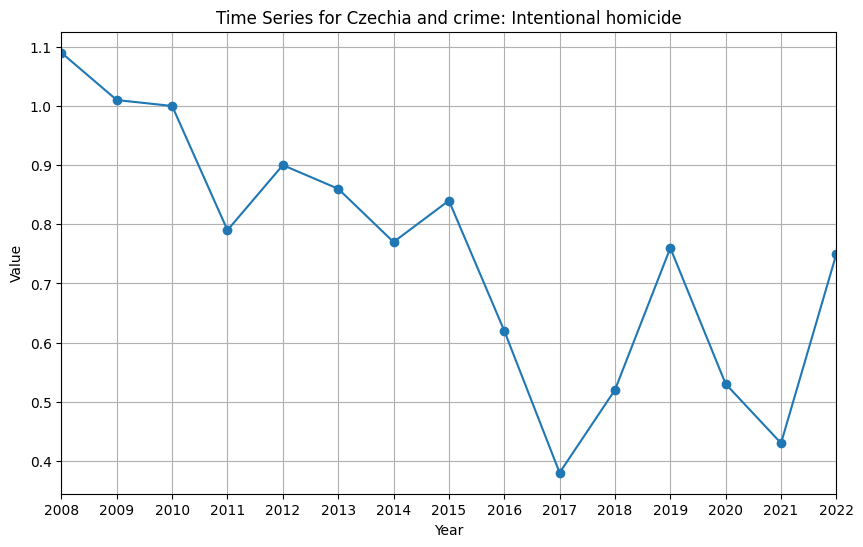

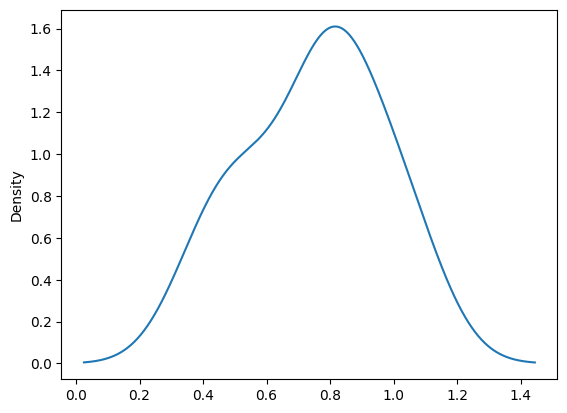

In [58]:
start_year, end_year = years_range.value
plt.figure(figsize=(10, 6))
plt.plot(CrimeData.filtered_data['year'], CrimeData.filtered_data['value'], marker='o')
plt.title(f"Time Series for {country.value} and crime: {crime.value}")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.xlim(start_year, end_year)
plt.xticks(range(start_year, end_year + 1, 1))
plt.show()

CrimeData.filtered_data['value'].plot.kde()
plt.show()

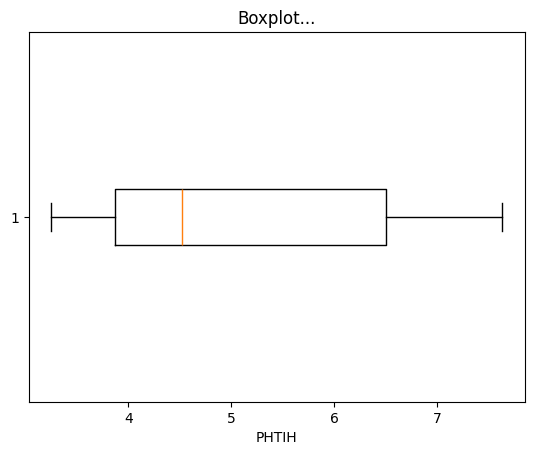

In [193]:
plt.boxplot(CrimeData.filtered_data['value'].dropna(), vert=False, showfliers=True)
plt.xlabel('PHTIH')
plt.title('Boxplot...')

# Show plot
plt.show()

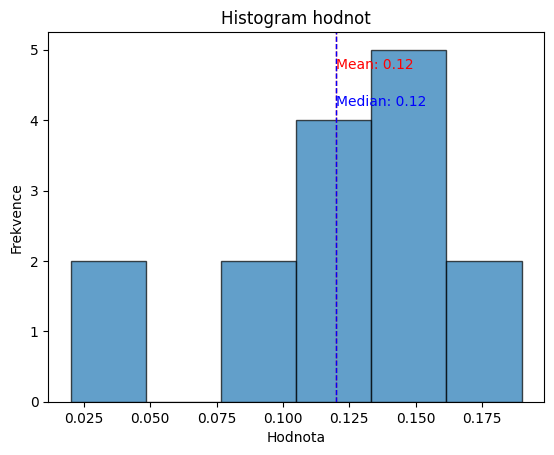

In [149]:
# import seaborn as sns
# sns.histplot(CrimeData.filtered_data['value'], bins=6, kde=True)
plt.hist(CrimeData.filtered_data['value'], bins=6, edgecolor='black', alpha=0.7)

# Přidání názvů a popisků
plt.title('Histogram hodnot')
plt.xlabel('Hodnota')
plt.ylabel('Frekvence')

# Mean line
plt.axvline(CrimeData.statistics.mean_value, color = 'red', linestyle='dashed', linewidth=1)
plt.text(CrimeData.statistics.mean_value, plt.ylim()[1]*0.9, f'Mean: {CrimeData.statistics.mean_value:.2f}', color = 'red')

# Median line
plt.axvline(CrimeData.statistics.median_value, color='blue', linestyle='dashed', linewidth=1)
plt.text(CrimeData.statistics.median_value, plt.ylim()[1]*0.8, f'Median: {CrimeData.statistics.median_value:.2f}', color='blue')



# Zobrazení grafu
plt.show()